# HOUSING IN BUENOS AIRES

The focus in this project  is to use predictive data science to predict apartment prices in Buenos Aires, Argentina. The data is gotten from properati.com. I will be creating a linear regression model using scikit-learn, building data pipelines and imputing missing values. 

In [5]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from category_encoders import OneHotEncoder



Firstly, write a wrangle function that subsets the data to return only apartments in Mexico City and cost less than $100000, handling outliers, cleaning the data to separate the coordinates, dropping null columns that are more than 50% null and also columns that cause multicollinearity

In [6]:
def wrangle(filename):
    df=pd.read_csv(filename, encoding='ISO-8859-1')
    
    #only apartments and cost less than 100000
    mask_price=df["price_aprox_usd"]<100_000
    mask_property=df["property_type"]=="apartment"
    mask_place=df["place_with_parent_names"].str.contains("Distrito Federal")
    
    df=df[mask_price & mask_property & mask_place] 
    
    #trim the bottom and top 10%
    low, high=df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_quantile= df["surface_covered_in_m2"].between(low, high)
    
    df=df[mask_quantile]
    
    #create new lat lon columns
    df[["lat", "lon"]]=df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    #create borough column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    #drop columns with na values>50%
    columns=(df.isna().sum()>500)
    columns=columns.index[columns==True]
    
    df.drop(columns=columns, inplace=True)
    
    #drop columns with high or low cardinality
    high_low=["properati_url", "currency", "property_type", "operation"]
    df.drop(columns=high_low, inplace=True)
    
    #drop coulmns that cause leakage
    leakage=["price_aprox_local_currency", "price_per_m2", "price"]
    df.drop(columns=leakage, inplace=True)
    
    df=df.reset_index().drop(columns="index")
    
    return df

In [7]:
df=wrangle("mexico housing.csv")

after loading and cleaning the data, we need to check the details of the dataframe by calling a method .info(). I am also interested in the shape of the DF and how the first 5 rows look

In [22]:
print(df.shape)
print(df.info())
df.head()


(5472, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5472 non-null   float64
 1   surface_covered_in_m2  5472 non-null   float64
 2   lat                    5147 non-null   float64
 3   lon                    5147 non-null   float64
 4   borough                5472 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5472 non-null   float64
 1   surface_covered_in_m2  5472 non-null   float64
 2   lat                    5147 non-null   float64
 3   lon                    5147 non-null   float64
 4   borough                5472 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB


I then drew a histogram of the data to get insight on how the data is distributed. 

The data looks to be slightly positively skewed

Text(0.5, 1.0, 'Distribution of Apartment Prices')

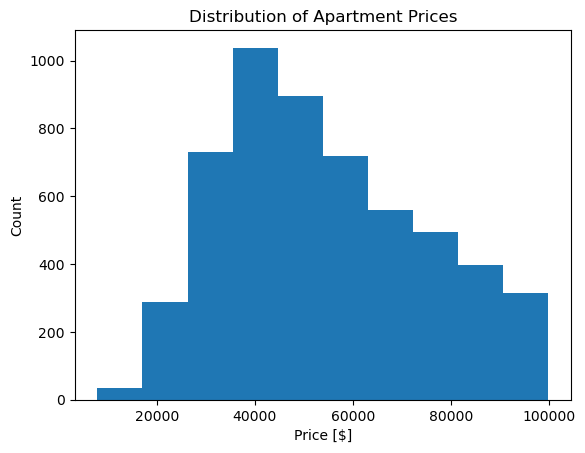

In [23]:
plt.hist(df["price_aprox_usd"])

# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices")

I then tried looking at the relationship between price and area. The visual shows a low correlation. Normally, you would expect that more area means higher price but the location of the building also matters. A small building can cost more because it might be in an area where the demand for property is high 

Text(0.5, 1.0, 'Distribution of Apartment Prices')

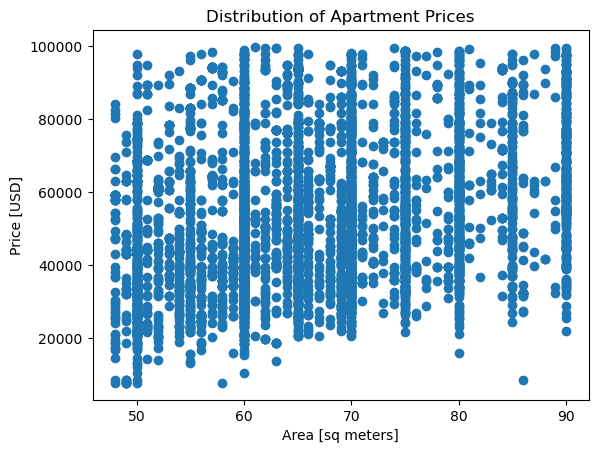

In [26]:
plt.scatter( x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])

#Add labels
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Distribution of Apartment Prices")


I have created a mapbox scatter plot that shows the location of the apartments in the dataset and their prices represented in color

In [28]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

I will now be splitting the data into a feature matrix and target vector. The target vector is the price of each building because that is the variable we are trying to predict. the features will be all the other columns except price that will be used to determing the price of an apartment

In [29]:
features=df.drop(columns="price_aprox_usd")
target="price_aprox_usd"
X_train = features
y_train = df[target]

I will be calculating the baseline mean absolute error

In [30]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54202.198002558485
Baseline MAE: 17206.49869506523


In order to build the model, I created a pipelinethat contains all the necessary transformers. The one hot encoder is used to turn categorical columns into numerical ones and the simple imputer helps with missing values in the data

In [32]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

I will be importing a test set to see how the model performs

In [36]:
y_pred_training=model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 14926.943376686464


In [33]:
X_test = pd.read_csv("mexico housing test.csv",  encoding='ISO-8859-1')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [34]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53606.013439
1    53323.532445
2    34336.343842
3    53556.125543
4    68707.558562
dtype: float64

Here are the 10 most important feature importances when determining apartment prices

In [37]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp

surface_covered_in_m2               284.991851
lat                                 490.410611
lon                               -2476.064277
borough_Benito Juárez             13816.975053
borough_Iztacalco                   379.533847
borough_Azcapotzalco               2503.681881
borough_Coyoacán                   3834.048801
borough_Álvaro Obregón             3043.701288
borough_Iztapalapa               -13368.102264
borough_Cuauhtémoc                 -319.440108
borough_Tláhuac                  -14208.659861
borough_Miguel Hidalgo             2004.646937
borough_Venustiano Carranza       -5609.969392
borough_Tlalpan                   10346.978177
borough_Gustavo A. Madero         -6631.577745
borough_Xochimilco                  948.122862
borough_La Magdalena Contreras    -5907.894678
borough_Cuajimalpa de Morelos      9167.955201
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

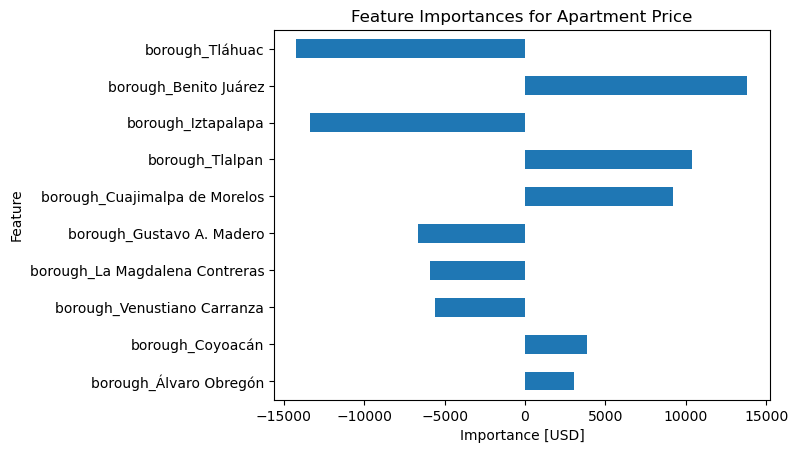

In [38]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importances for Apartment Price")